In [1]:
# import packages
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from bt_classes import my_backtest, test_indicator
# orig_df = pd.read_csv('../res/test_data.csv',index_col=0,parse_dates=True)
# my_backtest(orig_df[:500])
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# follow the literature
# we don't use min-max scaling here, use partial mean-std scaling instead
from sklearn.preprocessing import StandardScaler
from itertools import chain
rcParams['figure.figsize'] = 20,10
# df = pd.read_csv('../res/input0130.csv')

orig_df = pd.read_csv('../xau_1d_20y.csv')
orig_df['datetime'] = pd.to_datetime(orig_df['date'])
orig_df = orig_df.set_index('datetime')

df = orig_df.copy()
df['log_r'] = np.log(df['close']) - np.log(df['open'])
df['label'] = np.sign(df['log_r'].shift(-1))
df['label'][df['label']==-1] = 0
df['label'].fillna(0,inplace=True)

Using TensorFlow backend.


In [2]:
from tqdm import tqdm
from sa import *
from utils import *

# Please select the last activation layer.
layer_names = ['lstm_2']

default_upper_bound = 2000
default_n_bucket = 1000
default_n_classes = 2
class Args(): #创建一个类
    def __init__(self): #定义初始化信息。
        self.is_classification = True
        self.save_path = ''
        self.d = 'lstm_r'
        self.num_classes = 2
        self.lsa = True
        self.dsa = True
        self.target = 'none'
        self.batch_size = 128
        self.var_threshold = 1e-5
        self.upper_bound = 2000
        self.n_bucket = 1000
        self.is_classification = True
args = Args()

In [9]:
# reproduce training set
sample_len = 60
train_begin = sample_len
train_end = train_begin + 2000
scaler = StandardScaler()
train_set = df[['log_r','label']][train_begin-sample_len:train_end].reset_index()
x_train, y_train = [], []
x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
for i in range(sample_len,len(x_train_set)):
    x_train.append(x_train_set[i-sample_len:i])
    y_train.append(train_set['label'][i])
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = to_categorical(y_train,2)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

In [10]:
from keras.models import load_model
model = load_model(f'd{sample_len}-{2000+sample_len}.h5')  

In [11]:
test_begin = train_end
test_len = 1000
test_end = test_begin + test_len

x_test, y_test = [], []
test_set = df[['log_r','label']][test_begin-sample_len:test_end].reset_index()
y_true = df['label'][test_begin:test_end]
x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
for i in range(sample_len,len(x_test_set)):
    x_test.append(x_test_set[i-sample_len:i])
    y_test.append(test_set['label'][i])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
y_test = to_categorical(y_test,2)

y_pred = model.predict_classes(x_test)

test_df = orig_df[test_begin:test_end]
ti = test_indicator(y_true,y_pred,test_df)
# to_save = pd.DataFrame()
# to_save['y_true'] = y_true
# to_save['y_pred'] = y_pred
# to_save.to_csv(f'{test_begin}_{test_end}_test.csv')
# test_dsa = fetch_dsa(model, x_train, x_test, 'dsa from{}'.format(test_begin), layer_names, args)
# test_lsa = fetch_lsa(model, x_train, x_test, 'lsa from{}'.format(test_begin), layer_names, args)
# test_df['y_true'] = y_true
# test_df['y_pred'] = y_pred
# test_df['dsa'] = test_dsa
# test_df['lsa'] = test_lsa
# test_df['win'] = -1
# test_df['win'].loc[test_df['y_true']==test_df['y_pred']] = 1
# dsa_cov = get_sc(np.amin(test_dsa), 5, 20, test_dsa)
# lsa_cov = get_sc(np.amin(test_lsa), 1500, 20, test_lsa)
eva = model.evaluate(x_test, y_test)
print('Loss: {:.2f}, Accuracy: {:.2f}'.format(eva[0], eva[1]))
print("\nBefore adjusted:")
ti.backtest()
print("\nAfter adjusted:")
ti.backtest(prob_adjusted=True)
# print('Dsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa)))
# print('Lsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa)))
# backtest_df = orig_df[test_begin:test_end]
# backtest_df['label'] = y_pred
# sharpe,dd,ar = my_backtest(backtest_df)
# this_result = [test_begin,test_end,eva[0],eva[1],ti.get_precision(),ti.get_recall(),ti.get_successive_n_failure_rate(),dsa_cov,np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa),lsa_cov,np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa),sharpe,dd,ar,lsa_win_pearson,dsa_win_pearson,lsa_win_spearman,dsa_win_spearman]
# all_results.append(this_result)
# rs = pd.DataFrame(all_results,columns=['test_begin','test_end','loss','accuracy','precision','recall','snfr','dsa_cov','dsa_mean','dsa_std','dsa_max','dsa_min','lsa_cov','lsa_mean','lsa_std','lsa_max','lsa_min','sharpe','drawdown','annual','lsa_win_pearson','dsa_win_pearson','lsa_win_spearman','dsa_win_spearman'])
# rs.to_csv(f'new_rs_{sample_len}.csv')
out_begin = test_end
out_len = 1000
out_end = out_begin + out_len

x_out, y_out = [], []
out_set = df[['log_r','label']][out_begin-sample_len:out_end].reset_index()
y_true = df['label'][out_begin:out_end]
x_out_set = list(chain.from_iterable(scaler.transform(out_set['log_r'].values.reshape(-1,1))))
for i in range(sample_len,len(x_out_set)):
    x_out.append(x_out_set[i-sample_len:i])
    y_out.append(out_set['label'][i])
x_out, y_out = np.array(x_out), np.array(y_out)
x_out = np.reshape(x_out, (x_out.shape[0],x_out.shape[1],1)) 
y_out = to_categorical(y_out,2)

y_pred = model.predict_classes(x_out)

out_df = orig_df[out_begin:out_end]
ti2 = test_indicator(y_true, y_pred,out_df)

print("Out of sample test\nBefore adjusted:")
ti2.backtest()
# print("\nAfter self-adjusted:")
# ti2.backtest(prob_adjusted=True)
print("\nAfter adjusted:")
ti2.status_prob = ti.status_prob
ti2.backtest(prob_adjusted=True)

1000/1000 [==============================] - 2s 2ms/step
Loss: 0.70, Accuracy: 0.54

Before adjusted:
Accuracy: 0.5430
Starting Portfolio Value: 100000.00
Final Portfolio Value: 162720.00
Sharpe: 0.62
Max drawdown: 41.94%
Annual rate: 13.05%

After adjusted:
Adjusted accuracy: 0.7420
Starting Portfolio Value: 100000.00
Final Portfolio Value: 1078700.00
Sharpe: 4.08
Max drawdown: 11.78%
Annual rate: 82.09%


(4.075184743112191, 11.781926504198633, 82.0920440451866)


Before adjusted:
Accuracy: 0.5070
Starting Portfolio Value: 100000.00
Final Portfolio Value: 52894.00
Sharpe: -0.44
Max drawdown: 54.76%
Annual rate: -14.83%

After self-adjusted:
Adjusted accuracy: 0.9900
Starting Portfolio Value: 100000.00
Final Portfolio Value: 2629461.00
Sharpe: 9.21
Max drawdown: 2.30%
Annual rate: 127.93%

After inner-set adjusted:
Adjusted accuracy: 0.7790
Starting Portfolio Value: 100000.00
Final Portfolio Value: 479340.00
Sharpe: 3.29
Max drawdown: 7.91%
Annual rate: 48.43%


(3.2948880845009403, 7.9115186833209155, 48.430176962561625)

Adjusted accuracy: 0.7790
Starting Portfolio Value: 100000.00
Final Portfolio Value: 479340.00
Sharpe: 3.29
Max drawdown: 7.91%
Annual rate: 48.43%


(3.2948880845009403, 7.9115186833209155, 48.430176962561625)

In [22]:
def get_indicators(input_df,n=5):
    backtest_df = input_df
    backtest_df['label'] = input_df['y_pred']
    this_ti = test_indicator(input_df['y_true'],input_df['y_pred'])
    sharpe,dd,ar = my_backtest(backtest_df)
    this_result = [this_ti.get_entropy(),this_ti.get_accuracy(),this_ti.get_precision(),this_ti.get_recall(),this_ti.get_successive_n_failure_rate(n),this_ti.get_maximum_successive_failure(),np.mean(input_df['dsa']),np.std(input_df['dsa']),np.max(input_df['dsa']),np.min(input_df['dsa']),np.mean(input_df['lsa']),np.std(input_df['lsa']),np.max(input_df['lsa']),np.min(input_df['lsa']),sharpe,dd,ar]
    return this_result

In [93]:
suc_result, fail_result = ti.successive_distribution()

status_porb = {}
for i in range(len(suc_result)):
    fail = np.sum(suc_result[i])
    if i+1 < len(suc_result):
        success = np.sum(suc_result[i+1:])
    else: 
        success = 0
    status_porb[i] = success / (success + fail)

for i in range(len(fail_result)):
    success = np.sum(fail_result[i])
    if i+1 < len(fail_result):
        fail = np.sum(fail_result[i+1:])
    else: 
        fail = 0
    status_porb[-i] = success / (success + fail)

status_porb

{0: 0.0,
 1: 0.531496062992126,
 2: 0.4888888888888889,
 3: 0.6212121212121212,
 4: 0.6097560975609756,
 5: 0.4,
 6: 0.4,
 7: 0.5,
 8: 1.0,
 9: 1.0,
 10: 0.5,
 11: 0.0,
 -1: 0.5647058823529412,
 -2: 0.5585585585585585,
 -3: 0.5510204081632653,
 -4: 0.6818181818181818,
 -5: 0.42857142857142855,
 -6: 0.25,
 -7: 0.6666666666666666,
 -8: 1.0,
 -9: nan,
 -10: nan,
 -11: nan}

In [94]:
status_porb = {}
for i in range(len(suc_result)):
    fail = np.sum([j*suc_result[i][j] for j in range(len(suc_result[i]))])
    if i+1 < len(suc_result):
        success = np.sum([j*np.sum(suc_result[j]) for j in range(i+1,len(suc_result))])
    else: 
        success = 0
    status_porb[i] = success / (success + fail)

for i in range(len(fail_result)):
    success = np.sum([j*fail_result[i][j] for j in range(len(fail_result[i]))])
    if i+1 < len(fail_result):
        fail = np.sum([j*np.sum(fail_result[j]) for j in range(i+1,len(fail_result))])
    else: 
        fail = 0
    status_porb[-i] = success / (success + fail)
status_porb

{0: 0.0,
 1: 0.6757188498402555,
 2: 0.6985294117647058,
 3: 0.813953488372093,
 4: 0.8390804597701149,
 5: 0.7029702970297029,
 6: 0.7777777777777778,
 7: 0.84,
 8: 1.0,
 9: 1.0,
 10: 0.9166666666666666,
 11: 0.0,
 -1: 0.5024232633279483,
 -2: 0.425,
 -3: 0.3719512195121951,
 -4: 0.36764705882352944,
 -5: 0.125,
 -6: 0.08333333333333333,
 -7: 0.2727272727272727,
 -8: 1.0,
 -9: nan,
 -10: nan,
 -11: nan}

In [97]:
cum_success = []
test_df['suc_num'] = np.nan
test_df['suc_num'].loc[test_df['win']!=test_df['win'].shift(1)] = 1
test_df['suc_num'] = test_df['suc_num'].cumsum().fillna(method='ffill')
test_df['suc_num'] = test_df.groupby('suc_num')['suc_num'].cumsum() / test_df['suc_num'] * test_df['win']
test_df['suc_rate'] = test_df['suc_num'].map(status_porb)
test_df['label'] = test_df['y_pred']
test_df['label'].loc[test_df['suc_rate']<0.5] = 1 - test_df['label'].loc[test_df['suc_rate']<0.5]
my_backtest(test_df)

Starting Portfolio Value: 100000.00
Final Portfolio Value: 1078700.00
Sharpe: 4.08
Max drawdown: 11.78%
Annual rate: 82.09%


(4.075184743112191, 11.781926504198633, 82.0920440451866)

In [70]:
def get_cum_wl(df):
    return len(df) * df['win'].iloc[0]

In [81]:
test_df['suc_num'] = np.nan
test_df['suc_num'].loc[test_df['win']!=test_df['win'].shift(1)] = 1
test_df['suc_num'] = test_df['suc_num'].cumsum().fillna(method='ffill')

test_df.groupby('suc_num').apply(get_cum_wl).value_counts()

-1     155
 1     129
 2      69
-2      56
-3      35
 3      31
 4      14
-4      14
 5      11
 6       7
-5       4
-6       1
 12      1
 11      1
 10      1
dtype: int64

Starting Portfolio Value: 100000.00
Final Portfolio Value: 859.00
Sharpe: -0.88
Max drawdown: 102.73%
Annual rate: -69.84%


(-0.8818803958439742, 102.72856438658043, -69.8445178100753)

In [44]:
test_df

,date,open,high,low,close,y_true,y_pred,win,suc_num
datetime,,,,,,,,,
2007-11-26,1,823.99,836.92,821.80,824.60,0.0,1,-1,-1.0
2007-11-27,1,824.30,829.42,808.30,812.59,0.0,1,-1,-2.0
2007-11-28,1,812.72,815.40,792.03,804.83,0.0,1,-1,-3.0
2007-11-29,2007-11-29,804.78,808.10,792.50,793.07,0.0,1,-1,-4.0
2007-11-30,1,793.80,799.25,779.43,783.75,1.0,1,1,1.0
...,...,...,...,...,...,...,...,...,...
2011-09-19,1,1812.43,1828.74,1770.53,1778.68,1.0,0,-1,-1.0
2011-09-20,1,1778.98,1811.82,1770.07,1803.63,0.0,1,-1,-2.0
2011-09-21,1,1803.63,1816.70,1780.07,1782.35,0.0,1,-1,-3.0


In [32]:
all_result = []
window = 10
for i in range(len(test_df)):
    if i < window:
        all_result.append([0]*17)
    else:
        all_result.append(get_indicators(test_df.iloc[i-window:i],n=3))

: 100000.00
Final Portfolio Value: 101733.00
Sharpe: 1.91
Max drawdown: 3.28%
Annual rate: 54.18%
Starting Portfolio Value: 100000.00
Final Portfolio Value: 104880.00
Sharpe: 8.33
Max drawdown: 0.53%
Annual rate: 232.24%
Starting Portfolio Value: 100000.00
Final Portfolio Value: 102495.00
Sharpe: 5.17
Max drawdown: 0.60%
Annual rate: 86.08%
Starting Portfolio Value: 100000.00
Final Portfolio Value: 102390.00
Sharpe: 4.95
Max drawdown: 0.68%
Annual rate: 81.34%
Starting Portfolio Value: 100000.00
Final Portfolio Value: 101940.00
Sharpe: 3.80
Max drawdown: 0.71%
Annual rate: 62.29%
Starting Portfolio Value: 100000.00
Final Portfolio Value: 103820.00
Sharpe: 7.67
Max drawdown: 0.68%
Annual rate: 157.21%
Starting Portfolio Value: 100000.00
Final Portfolio Value: 101983.00
Sharpe: 5.06
Max drawdown: 0.69%
Annual rate: 64.02%
Starting Portfolio Value: 100000.00
Final Portfolio Value: 103753.00
Sharpe: 9.99
Max drawdown: 0.69%
Annual rate: 153.06%
Starting Portfolio Value: 100000.00
Final Por

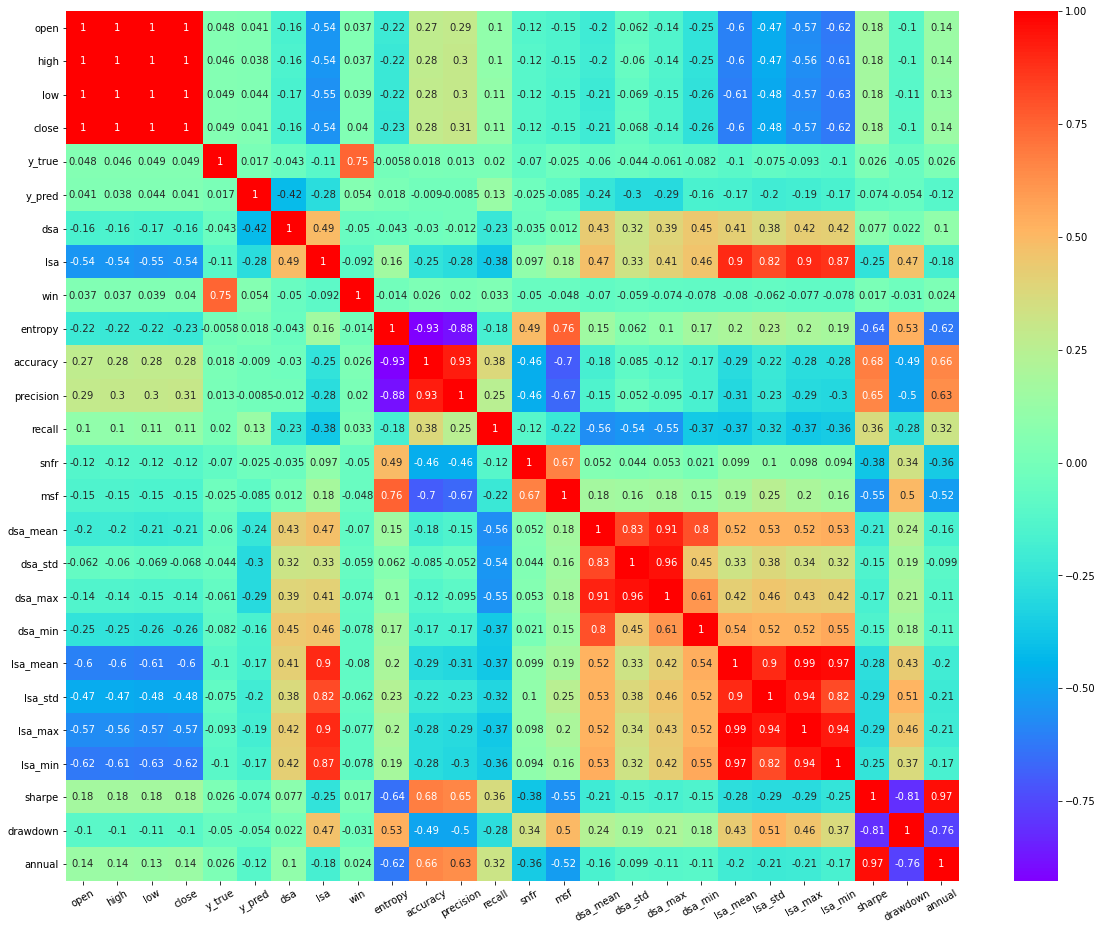

In [34]:
cols = ['entropy','accuracy','precision','recall','snfr','msf','dsa_mean','dsa_std','dsa_max','dsa_min','lsa_mean','lsa_std','lsa_max','lsa_min','sharpe','drawdown','annual']
res = pd.DataFrame(all_result,columns=cols)
merged = pd.merge(test_df.reset_index(),res,left_index=True,right_index=True)

plt.figure(figsize=(20,16))
sns.heatmap(merged.corr(method='spearman'),annot=True,cmap='rainbow')
plt.xticks(rotation=30)
plt.show()